In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.infer import Importance, EmpiricalMarginal, SMCFilter
from pyro.nn.module import PyroParam, PyroModule, PyroSample
from pyro.contrib.gp import Parameterized
import pyro.contrib.gp as gp
plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("/mnt/dl/machine_learning_dataset/coal_mine_disasters_uk/coal_mining_disasters_uk.csv")

In [3]:
data

,Year,Count
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1855,0
...,...,...
107,1958,0
108,1959,0
109,1960,1
110,1961,0


<BarContainer object of 112 artists>

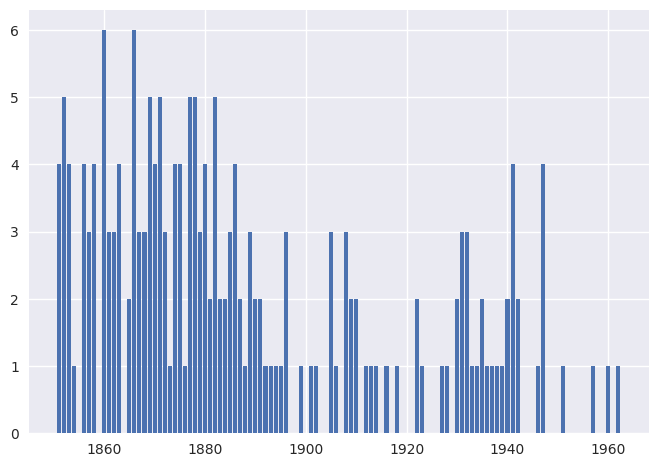

In [4]:
plt.bar(data.Year, data.Count)

(array([33., 31.,  0., 14.,  0., 14., 12.,  0.,  6.,  2.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

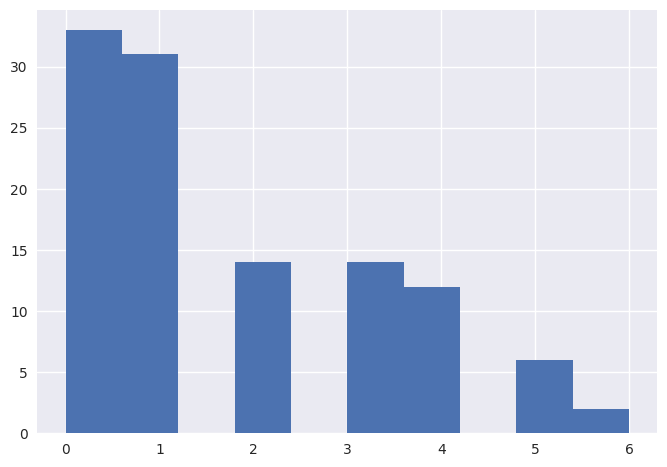

In [5]:
plt.hist(data.Count, bins=10)

In [6]:
x = torch.tensor(data.Year).float()
y = torch.tensor(data.Count).long()

In [7]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
kernel = gp.kernels.Matern32(input_dim=1, 
                             variance=torch.tensor(1.0), 
                             lengthscale=torch.tensor(0.5))
likelihood = gp.likelihoods.Poisson()
model = gp.models.VariationalGP(X=x, 
                                y=y, 
                                kernel=kernel,
                                likelihood=likelihood, 
                                whiten=True)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-2
                             )
elbo = infer.TraceMeanField_ELBO()
loss_fn = elbo.differentiable_loss
losses = []
for i in range(500):
    loss = loss_fn(model.model, model.guide) / len(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

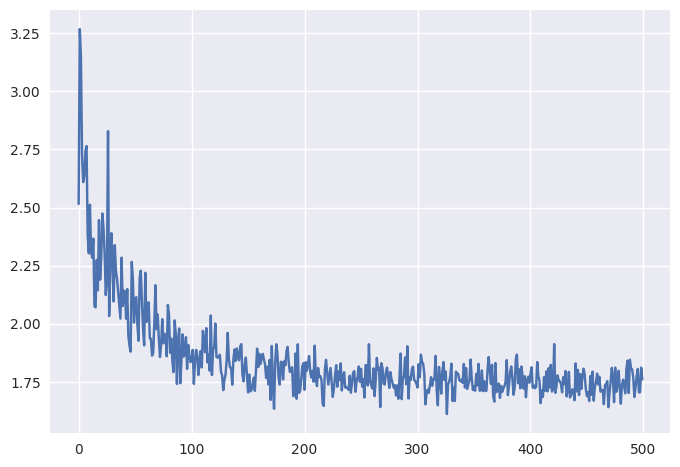

In [8]:
plt.plot(losses)

In [9]:
with torch.no_grad():
    mean, var = model(x)

In [10]:
l = likelihood(mean, var)

In [11]:
l

tensor([0., 0., 2., 0., 2., 0., 0., 5., 0., 0., 2., 5., 1., 0., 1., 5., 2., 3.,
        4., 2., 5., 0., 4., 3., 3., 2., 6., 4., 3., 3., 0., 2., 4., 2., 2., 2.,
        0., 0., 0., 0., 5., 3., 0., 0., 0., 5., 0., 1., 1., 1., 3., 3., 0., 0.,
        0., 0., 1., 0., 2., 2., 1., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 7., 2., 2., 0., 0., 1., 1., 1., 3., 3.,
        3., 0., 0., 1., 0., 1., 3., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.])

In [12]:
y

tensor([4, 5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1, 4,
        4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
        1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2,
        1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 0, 1,
        4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [13]:
(l.long() == y).sum() * 100. / len(y)

tensor(29.4643)

In [14]:
print(model.kernel.variance_unconstrained)

Parameter containing:
tensor(-0.5438, requires_grad=True)


In [15]:
kernel.variance

tensor(0.5805, grad_fn=<AddBackward0>)

/env_nlp/lib/python3.9/site-packages/pyro/infer/trace_mean_field_elbo.py:38: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  kernel.lengthscale
  kernel.variance
  fGuide sites:
  kernel.variance
  kernel.lengthscale
  f
  warnings.warn(


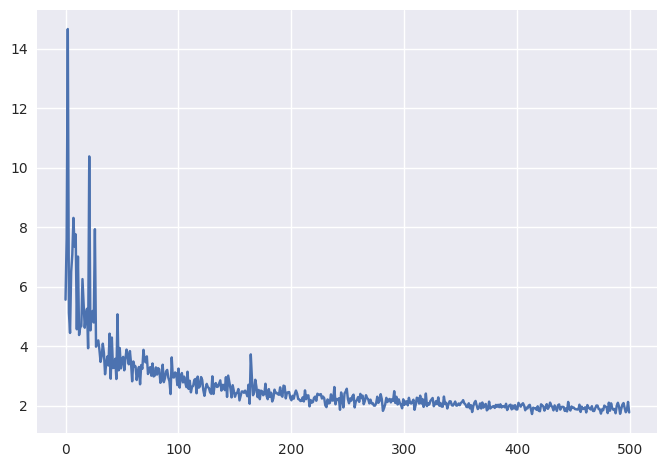

In [16]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
kernel = gp.kernels.Matern32(input_dim=1, 
                             variance=torch.tensor(1.0), 
                             lengthscale=torch.tensor(0.5))
likelihood = gp.likelihoods.Poisson()
model = gp.models.VariationalGP(X=x, 
                                y=y, 
                                kernel=kernel,
                                likelihood=likelihood, 
                                whiten=True)
model.kernel.variance = PyroSample(dist.LogNormal(0., 1.))
model.kernel.lengthscale = PyroSample(dist.LogNormal(0., 1.))

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-2
                             )
elbo = infer.TraceMeanField_ELBO()
loss_fn = elbo.differentiable_loss
losses = []
for i in range(500):
    loss = loss_fn(model.model, model.guide) / len(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

In [17]:
model.kernel.lengthscale_map_unconstrained

Parameter containing:
tensor(-0.1080, requires_grad=True)

In [18]:
list(model.named_parameters())

[('f_loc',
  Parameter containing:
  tensor([ 0.7967,  0.7877,  0.4487, -0.4295, -0.2057,  0.7565,  0.1694,  0.3673,
          -0.1523,  0.9286,  0.3070,  0.5306,  0.3852, -0.5493,  0.3548,  1.1610,
           0.1113,  0.5843,  0.7518,  0.6325,  0.6337,  0.2217,  0.0330,  0.1892,
           0.7638, -0.0682,  0.9653,  0.3433,  0.4558,  0.6182,  0.2005,  0.9259,
          -0.0727,  0.1075,  0.4923,  0.7237,  0.0291, -0.1244,  0.4923,  0.0375,
           0.0239, -0.2206, -0.1982, -0.1990,  0.1480,  0.3917, -0.6539, -0.4580,
          -0.2312, -0.5249, -0.1347, -0.2620, -0.6669, -0.1893,  0.4411, -0.3614,
          -0.3187,  0.7322,  0.0915, -0.0133, -0.6122, -0.0697, -0.1152, -0.2421,
          -0.5589, -0.2601, -0.3329, -0.2501, -0.8015, -0.6917, -0.3427,  0.1510,
          -0.3012, -0.7987, -0.4909, -0.5494, -0.0843, -0.2353, -0.5055,  0.5369,
           0.5199,  0.3266, -0.3139, -0.1194,  0.2681, -0.2504, -0.1417, -0.1646,
          -0.1393,  0.2228,  0.7357, -0.1916, -0.7914, -0.6889,

[('f_loc', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)), ('f_scale_tril_unconstrained', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)), ('kernel.variance_loc', Parameter containing:
tensor(-2.1788, requires_grad=True)), ('kernel.variance_scale_unconstraine

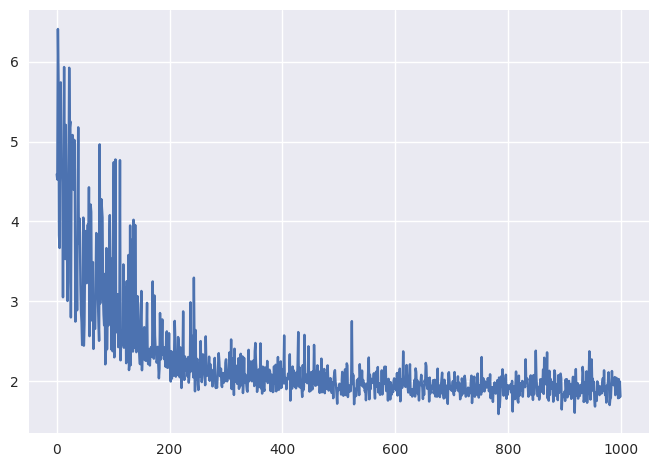

In [19]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
kernel = gp.kernels.Matern32(input_dim=1, 
                             variance=torch.tensor(1.0), 
                             lengthscale=torch.tensor(0.5))
likelihood = gp.likelihoods.Poisson()
model = gp.models.VariationalGP(X=x, 
                                y=y, 
                                kernel=kernel,
                                likelihood=likelihood, 
                                jitter=9e-2)
model.kernel.variance = PyroSample(dist.LogNormal(0., 1.))
model.kernel.lengthscale = PyroSample(dist.LogNormal(0., 1.))
model.kernel.autoguide("variance", dist.Normal)
model.kernel.autoguide("lengthscale", dist.Normal)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-2
                             )
print(list(model.named_parameters()))
elbo = infer.Trace_ELBO()
loss_fn = elbo.differentiable_loss
losses = []
for i in range(1000):
    loss = loss_fn(model.model, model.guide) / len(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

In [20]:
print(list(model.named_parameters()))

[('f_loc', Parameter containing:
tensor([ 0.9411,  1.1397,  0.9325, -0.0119, -0.3905,  0.8876,  0.7990,  0.8618,
        -0.1333,  1.3570,  0.7703,  0.7434,  0.8421, -0.3471,  0.3642,  1.3276,
         0.7616,  0.7368,  1.1867,  1.0105,  1.2074,  0.6602,  0.0711,  0.9597,
         0.9269,  0.1407,  1.1967,  1.3167,  0.6965,  0.9050,  0.5301,  1.0346,
         0.4003,  0.2990,  0.7623,  0.8736,  0.3813,  0.0335,  0.6124,  0.4149,
         0.2806, -0.0965, -0.1166, -0.1601, -0.0306,  0.5356, -0.4552, -0.6372,
        -0.1932, -0.5257, -0.1571, -0.1325, -0.6199, -0.3779,  0.5068, -0.0087,
        -0.3916,  0.5781,  0.4374,  0.2864, -0.5472, -0.1605, -0.1042, -0.1669,
        -0.6389, -0.2311, -0.5577, -0.2495, -0.6894, -0.6443, -0.4838,  0.1860,
        -0.0840, -0.5777, -0.7535, -0.5961, -0.1677, -0.1530, -0.5145,  0.2795,
         0.6988,  0.6172, -0.0336, -0.0846,  0.2637, -0.0798, -0.1618, -0.1088,
        -0.1250,  0.3843,  0.8989,  0.3715, -0.6270, -0.6854, -0.6415, -0.0620,
       

In [21]:
model.set_mode("guide")

In [22]:
with torch.no_grad():
    mean, var = model(x)
    l = likelihood(mean, var)


In [23]:
(l == y).sum() / len(x)

tensor(0.2500)